## Distance-Based Speech Recognition System

This notebook implements a complete **Distance-Based Speech Recognition** pipeline using classical DSP techniques.

###  Pipeline Overview
| 1      | Environment Setup & Dataset Download 

| 2      | Data Loading & Integrity Verification 

| 3      | Preprocessing (DC removal, pre-emphasis, normalization, duplicate removal)

| 4      | Framing (25 ms frames, 10 ms hop, Hamming window, 60% overlap) 

| 5      | Train / Test Split (80%–20%)     

| 6      | Feature Extraction – Magnitude Spectrum using FFT           

| 7      | Template Creation – One average spectrum per class (from training)

| 8      | Distance-based Classification (Euclidean distance on flattened spectra)

| 9      | Accuracy Calculation & Per-class Results

### Compatibility
This notebook runs on:
-  Local Python environment
-  Google Colab
-  Kaggle Notebooks



## Import Libraries

In [27]:
import sys
import os
import numpy as np
import hashlib
import json
import zipfile
import urllib.request
from pathlib import Path
from dataclasses import dataclass
from typing import List, Dict, Tuple, Any
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


## Environment Setup

In [2]:
# 1.1 Detect Runtime Environment
def detect_environment():
    """Detect if running on Colab, Kaggle, or Local."""
    if 'google.colab' in sys.modules:
        return 'colab'
    elif 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
        return 'kaggle'
    else:
        return 'local'

ENVIRONMENT = detect_environment()
print(f"Running on: {ENVIRONMENT.upper()}")

Running on: KAGGLE


In [3]:
# 1.2 Download and Extract Dataset
# Dataset URL
DATASET_URL = "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip"

# Set paths based on environment
if ENVIRONMENT == 'colab':
    BASE_PATH = Path("/content")
elif ENVIRONMENT == 'kaggle':
    BASE_PATH = Path("/kaggle/working")
else:
    BASE_PATH = Path(".")  # Current directory for local

DATASET_ZIP = BASE_PATH / "mini_speech_commands.zip"
# Note: The zip extracts to mini_speech_commands/mini_speech_commands (nested)
DATASET_EXTRACT_PATH = BASE_PATH / "mini_speech_commands"
DATASET_PATH = DATASET_EXTRACT_PATH / "mini_speech_commands"

def download_dataset():
    """Download dataset if not already present."""
    # Check if the actual data directory exists (with labels inside)
    if DATASET_PATH.exists() and (DATASET_PATH / "down").exists():
        print(f"Dataset already exists at: {DATASET_PATH}")
        return
    
    if not DATASET_ZIP.exists():
        print(f"Downloading dataset from Google Storage...")
        urllib.request.urlretrieve(DATASET_URL, DATASET_ZIP)
        print(f"Downloaded to: {DATASET_ZIP}")
    
    print(f"Extracting dataset...")
    with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
        zip_ref.extractall(BASE_PATH)
    print(f"Extracted to: {DATASET_PATH}")

download_dataset()

Downloaded to: /kaggle/working/mini_speech_commands.zip
Extracting dataset...
Extracted to: /kaggle/working/mini_speech_commands/mini_speech_commands


## Configuration

In [4]:
# 1.3 Configuration Constants
class Config:
    """Central configuration for the entire pipeline."""
    
    # Paths
    DATASET_PATH = DATASET_PATH
    PROCESSED_DATA_DIR = BASE_PATH / "processed_data"
    
    # Audio settings
    SAMPLE_RATE = 16000          # Expected sample rate (Hz)
    AUDIO_DURATION_SEC = 1.0     # Expected duration (seconds)
    EXPECTED_SAMPLES = int(SAMPLE_RATE * AUDIO_DURATION_SEC)  # 16000 samples
    
    # Class labels (8 speech commands)
    LABELS = ["down", "go", "left", "no", "right", "stop", "up", "yes"]
    
    # Framing settings
    FRAME_LENGTH_MS = 25.0       # Frame length in milliseconds
    HOP_LENGTH_MS = 10.0         # Hop length in milliseconds
    WINDOW_TYPE = 'hamming'      # Window function
    
    # Preprocessing settings
    PREEMPHASIS_COEFF = 0.97     # Pre-emphasis filter coefficient
    
    @classmethod
    def frame_samples(cls):
        """Get frame length in samples."""
        return int(cls.SAMPLE_RATE * cls.FRAME_LENGTH_MS / 1000)
    
    @classmethod
    def hop_samples(cls):
        """Get hop length in samples."""
        return int(cls.SAMPLE_RATE * cls.HOP_LENGTH_MS / 1000)

# Print configuration
print("Configuration:")
print(f"  Sample Rate: {Config.SAMPLE_RATE} Hz")
print(f"  Audio Duration: {Config.AUDIO_DURATION_SEC}s ({Config.EXPECTED_SAMPLES} samples)")
print(f"  Frame Length: {Config.FRAME_LENGTH_MS}ms ({Config.frame_samples()} samples)")
print(f"  Hop Length: {Config.HOP_LENGTH_MS}ms ({Config.hop_samples()} samples)")
print(f"  Overlap: {Config.FRAME_LENGTH_MS - Config.HOP_LENGTH_MS}ms ({(Config.FRAME_LENGTH_MS - Config.HOP_LENGTH_MS)/Config.FRAME_LENGTH_MS*100:.0f}%)")
print(f"  Labels: {Config.LABELS}")

Configuration:
  Sample Rate: 16000 Hz
  Audio Duration: 1.0s (16000 samples)
  Frame Length: 25.0ms (400 samples)
  Hop Length: 10.0ms (160 samples)
  Overlap: 15.0ms (60%)
  Labels: ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']


---
## Data Loading

This section handles:
- Discovering all audio files in the dataset
- Loading WAV files into memory
- Verifying dataset integrity (sample rates, durations)

In [5]:
# 2.1 AudioSample Data Class
@dataclass
class AudioSample:
    """
    Represents a single audio sample with metadata.
    
    Attributes:
        filepath: Path to the original WAV file
        label: Speech command label (e.g., 'down', 'go')
        sample_rate: Audio sample rate in Hz
        data: Raw audio signal as numpy array
    """
    filepath: Path
    label: str
    sample_rate: int
    data: np.ndarray
    
    def duration_sec(self) -> float:
        """Calculate duration in seconds."""
        return len(self.data) / self.sample_rate
    
    def __repr__(self):
        return f"AudioSample(label='{self.label}', duration={self.duration_sec():.3f}s)"

In [6]:
# 2.2 Data Loading Functions
def get_audio_files_for_label(label: str) -> List[Path]:
    """
    Retrieve all .wav file paths for a specific label.
    
    Args:
        label: The class label (e.g., 'down', 'go')
    
    Returns:
        Sorted list of Path objects pointing to audio files
    """
    label_dir = Config.DATASET_PATH / label
    if not label_dir.exists():
        raise FileNotFoundError(f"Label directory not found: {label_dir}")
    return sorted(label_dir.glob("*.wav"))


def load_audio_file(filepath: Path) -> Tuple[int, np.ndarray]:
    """
    Load a single WAV audio file.
    
    Args:
        filepath: Path to the .wav file
    
    Returns:
        Tuple of (sample_rate, audio_data as float32)
    """
    sample_rate, data = wav.read(filepath)
    return sample_rate, data.astype(np.float32)


def discover_dataset() -> Dict[str, List[Path]]:
    """
    Discover all audio files in the dataset, organized by label.
    
    Returns:
        Dictionary mapping labels to lists of file paths
    """
    return {label: get_audio_files_for_label(label) for label in Config.LABELS}


def load_dataset() -> List[AudioSample]:
    """
    Load all audio samples from the dataset.
    
    Returns:
        List of AudioSample objects
    """
    samples = []
    file_map = discover_dataset()
    
    for label, filepaths in file_map.items():
        for filepath in filepaths:
            sample_rate, data = load_audio_file(filepath)
            samples.append(AudioSample(
                filepath=filepath,
                label=label,
                sample_rate=sample_rate,
                data=data
            ))
    
    return samples

print("Data loading functions defined")

Data loading functions defined


In [7]:
# 2.3 Dataset Integrity Verification
def verify_dataset_integrity(samples: List[AudioSample]) -> Dict[str, Any]:
    """
    Verify dataset integrity and collect statistics.
    
    Args:
        samples: List of loaded AudioSample objects
    
    Returns:
        Dictionary containing verification results and statistics
    """
    stats = {
        "total_samples": len(samples),
        "samples_per_label": {label: 0 for label in Config.LABELS},
        "sample_rate_issues": [],
        "duration_issues": [],
        "all_sample_rates": set(),
        "duration_stats": {"min": float('inf'), "max": 0, "durations": []},
        "is_valid": True
    }
    
    for sample in samples:
        # Count per label
        stats["samples_per_label"][sample.label] += 1
        
        # Track sample rates
        stats["all_sample_rates"].add(sample.sample_rate)
        
        # Check sample rate
        if sample.sample_rate != Config.SAMPLE_RATE:
            stats["sample_rate_issues"].append(sample.filepath.name)
        
        # Calculate duration
        duration = sample.duration_sec()
        stats["duration_stats"]["durations"].append(duration)
        stats["duration_stats"]["min"] = min(stats["duration_stats"]["min"], duration)
        stats["duration_stats"]["max"] = max(stats["duration_stats"]["max"], duration)
        
        # Check for unusual duration (>10% deviation)
        if abs(len(sample.data) - Config.EXPECTED_SAMPLES) > Config.SAMPLE_RATE * 0.1:
            stats["duration_issues"].append(sample.filepath.name)
    
    stats["duration_stats"]["mean"] = np.mean(stats["duration_stats"]["durations"])
    stats["is_valid"] = len(stats["sample_rate_issues"]) == 0
    
    return stats

print("Verification functions defined")

Verification functions defined


In [12]:
CORRECT_PATH = Path("/kaggle/working/mini_speech_commands")

# Verify it really exists and has the 8 folders are there
print("Contents of /kaggle/working/mini_speech_commands :")
print([p.name for p in CORRECT_PATH.iterdir() if p.is_dir()])

# Force-correct the path in Config
Config.DATASET_PATH = CORRECT_PATH

print(f"Config.DATASET_PATH is now → {Config.DATASET_PATH}")
print(f"Number of label folders → {len(list(Config.DATASET_PATH.iterdir()))}")

Contents of /kaggle/working/mini_speech_commands :
['no', 'up', 'go', 'stop', 'left', 'down', 'right', 'yes']
Config.DATASET_PATH is now → /kaggle/working/mini_speech_commands
Number of label folders → 9


In [14]:
# 2.4 Load and Verify Dataset
print("Loading dataset...")
samples = load_dataset()
print(f"Loaded {len(samples)} audio samples")

print("\nVerifying dataset integrity...")
stats = verify_dataset_integrity(samples)

# Print summary
print("\n" + "="*60)
print("📊 DATASET SUMMARY")
print("="*60)
print(f"\nTotal Samples: {stats['total_samples']}")

print("\n📁 Samples per Label:")
for label, count in stats['samples_per_label'].items():
    print(f"   {label:>8}: {count:>4} files")

print(f"\n🎵 Sample Rates Found: {stats['all_sample_rates']}")
print(f"\n⏱️  Duration Statistics:")
print(f"   Min: {stats['duration_stats']['min']:.3f}s")
print(f"   Max: {stats['duration_stats']['max']:.3f}s")
print(f"   Mean: {stats['duration_stats']['mean']:.3f}s")

if stats['sample_rate_issues']:
    print(f"\n⚠️  Sample Rate Issues: {len(stats['sample_rate_issues'])} files")
else:
    print("\n✅ All files have consistent sample rate (16kHz)")

if stats['duration_issues']:
    print(f"⚠️ Duration Issues: {len(stats['duration_issues'])} files (will be padded)")
else:
    print("✅ All files have expected duration")

Loading dataset...
Loaded 8000 audio samples

Verifying dataset integrity...

📊 DATASET SUMMARY

Total Samples: 8000

📁 Samples per Label:
       down: 1000 files
         go: 1000 files
       left: 1000 files
         no: 1000 files
      right: 1000 files
       stop: 1000 files
         up: 1000 files
        yes: 1000 files

🎵 Sample Rates Found: {16000}

⏱️  Duration Statistics:
   Min: 0.427s
   Max: 1.000s
   Mean: 0.984s

✅ All files have consistent sample rate (16kHz)
⚠️ Duration Issues: 527 files (will be padded)


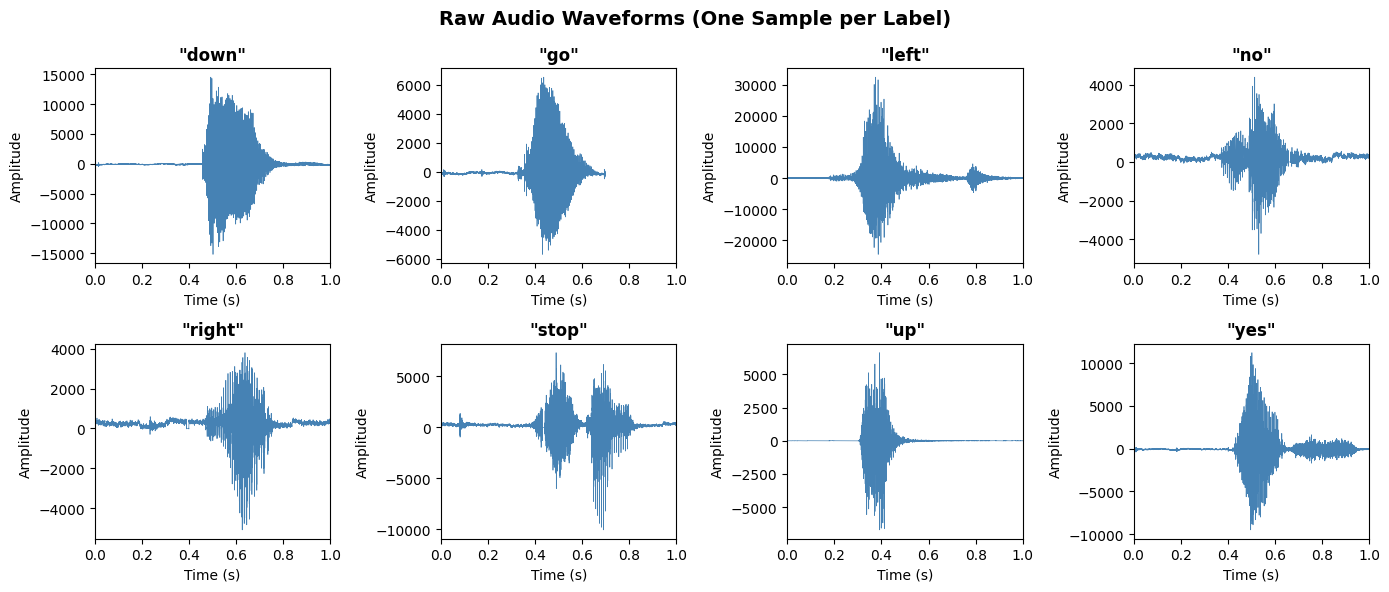

In [15]:
# 2.5 Visualize Sample Audio Waveforms
def plot_sample_waveforms(samples: List[AudioSample], num_per_label: int = 1):
    """Plot sample waveforms for each label."""
    fig, axes = plt.subplots(2, 4, figsize=(14, 6))
    axes = axes.flatten()
    
    label_samples = {label: [] for label in Config.LABELS}
    for s in samples:
        if len(label_samples[s.label]) < num_per_label:
            label_samples[s.label].append(s)
    
    for idx, label in enumerate(Config.LABELS):
        ax = axes[idx]
        sample = label_samples[label][0]
        time = np.arange(len(sample.data)) / sample.sample_rate
        
        ax.plot(time, sample.data, linewidth=0.5, color='steelblue')
        ax.set_title(f'"{label}"', fontsize=12, fontweight='bold')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
        ax.set_xlim(0, 1)
    
    plt.suptitle('Raw Audio Waveforms (One Sample per Label)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_sample_waveforms(samples)

---
## Preprocessing

This section applies the following preprocessing steps:
1. **Duplicate Detection** - Remove identical audio files
2. **DC Offset Removal** - Center signal at zero
3. **Length Normalization** - Pad/truncate to fixed length
4. **Pre-emphasis Filter** - Boost high frequencies
5. **Amplitude Normalization** - Scale to [-1, 1]

In [16]:
# 3.1 Duplicate Detection Functions
def compute_audio_hash(audio: np.ndarray) -> str:
    """
    Compute MD5 hash for audio content to detect duplicates.
    
    Args:
        audio: Audio signal array
    
    Returns:
        MD5 hash string
    """
    rounded = np.round(audio, decimals=4)
    return hashlib.md5(rounded.tobytes()).hexdigest()


def find_duplicate_indices(audio_list: List[np.ndarray]) -> List[int]:
    """
    Find indices of duplicate audio samples.
    
    Args:
        audio_list: List of audio arrays
    
    Returns:
        List of indices that are duplicates (keeps first occurrence)
    """
    seen_hashes = {}
    duplicate_indices = []
    
    for idx, audio in enumerate(audio_list):
        audio_hash = compute_audio_hash(audio)
        if audio_hash in seen_hashes:
            duplicate_indices.append(idx)
        else:
            seen_hashes[audio_hash] = idx
    
    return duplicate_indices


def remove_duplicates(samples: List[AudioSample]) -> List[AudioSample]:
    """
    Remove duplicate audio samples from the dataset.
    
    Args:
        samples: List of AudioSample objects
    
    Returns:
        List with duplicates removed
    """
    audio_list = [s.data for s in samples]
    duplicate_indices = set(find_duplicate_indices(audio_list))
    return [s for i, s in enumerate(samples) if i not in duplicate_indices]

print("Duplicate detection functions defined")

Duplicate detection functions defined


In [17]:
# 3.2 Audio Preprocessing Functions
def remove_dc_offset(audio: np.ndarray) -> np.ndarray:
    """
    Remove DC offset (mean) from audio signal.
    Centers the signal around zero.
    
    Args:
        audio: Input audio signal
    
    Returns:
        Audio signal with zero mean
    """
    return audio - np.mean(audio)


def normalize_to_fixed_length(audio: np.ndarray, 
                               target_length: int = Config.EXPECTED_SAMPLES) -> np.ndarray:
    """
    Pad or truncate audio to fixed length.
    - Shorter signals: zero-padded at the end
    - Longer signals: truncated
    
    Args:
        audio: Input audio signal
        target_length: Desired output length in samples
    
    Returns:
        Audio signal with exactly target_length samples
    """
    current_length = len(audio)
    
    if current_length == target_length:
        return audio
    elif current_length < target_length:
        # Pad with zeros
        return np.pad(audio, (0, target_length - current_length), mode='constant')
    else:
        # Truncate
        return audio[:target_length]


def apply_preemphasis(audio: np.ndarray, 
                      coeff: float = Config.PREEMPHASIS_COEFF) -> np.ndarray:
    """
    Apply pre-emphasis filter to boost high frequencies.
    Formula: y[n] = x[n] - coeff * x[n-1]
    
    This helps balance the frequency spectrum since speech
    typically has more energy in low frequencies.
    
    Args:
        audio: Input audio signal
        coeff: Pre-emphasis coefficient (typically 0.95-0.97)
    
    Returns:
        Pre-emphasized audio signal
    """
    return np.append(audio[0], audio[1:] - coeff * audio[:-1])


def normalize_amplitude(audio: np.ndarray) -> np.ndarray:
    """
    Normalize audio amplitude to [-1, 1] range using peak normalization.
    
    Args:
        audio: Input audio signal
    
    Returns:
        Normalized audio signal
    """
    max_val = np.max(np.abs(audio))
    if max_val > 0:
        return audio / max_val
    return audio

print("Preprocessing functions defined")

Preprocessing functions defined


In [18]:
# 3.3 Complete Preprocessing Pipeline
def preprocess_audio(audio: np.ndarray,
                     remove_dc: bool = True,
                     apply_preemph: bool = True,
                     preemph_coeff: float = Config.PREEMPHASIS_COEFF,
                     normalize: bool = True,
                     target_length: int = Config.EXPECTED_SAMPLES) -> np.ndarray:
    """
    Apply complete preprocessing pipeline to a single audio sample.
    
    Pipeline order:
    1. Remove DC offset (center at zero)
    2. Normalize to fixed length (pad/truncate)
    3. Apply pre-emphasis (boost high frequencies)
    4. Normalize amplitude (scale to [-1, 1])
    
    Args:
        audio: Raw audio signal
        remove_dc: Whether to remove DC offset
        apply_preemph: Whether to apply pre-emphasis
        preemph_coeff: Pre-emphasis coefficient
        normalize: Whether to normalize amplitude
        target_length: Target length for padding/truncation
    
    Returns:
        Preprocessed audio signal
    """
    result = audio.copy()
    
    # Step 1: Remove DC offset
    if remove_dc:
        result = remove_dc_offset(result)
    
    # Step 2: Normalize to fixed length
    result = normalize_to_fixed_length(result, target_length)
    
    # Step 3: Apply pre-emphasis
    if apply_preemph:
        result = apply_preemphasis(result, preemph_coeff)
    
    # Step 4: Normalize amplitude
    if normalize:
        result = normalize_amplitude(result)
    
    return result

print("Preprocessing pipeline defined")

Preprocessing pipeline defined


In [19]:
# 3.4 Apply Preprocessing to Dataset
print("Checking for duplicates...")
original_count = len(samples)
cleaned_samples = remove_duplicates(samples)
cleaned_count = len(cleaned_samples)
duplicates_removed = original_count - cleaned_count
print(f"Removed {duplicates_removed} duplicate files")
print(f"   {original_count} → {cleaned_count} samples")

print("\nApplying preprocessing pipeline...")
preprocessed_audio = []
for sample in cleaned_samples:
    processed = preprocess_audio(sample.data)
    preprocessed_audio.append(processed)

preprocessed_audio = np.array(preprocessed_audio, dtype=np.float32)
labels = np.array([s.label for s in cleaned_samples])

print(f"Preprocessed {len(preprocessed_audio)} samples")
print(f"Shape: {preprocessed_audio.shape}")
print(f"Dtype: {preprocessed_audio.dtype}")

Checking for duplicates...
Removed 27 duplicate files
   8000 → 7973 samples

Applying preprocessing pipeline...
Preprocessed 7973 samples
Shape: (7973, 16000)
Dtype: float32


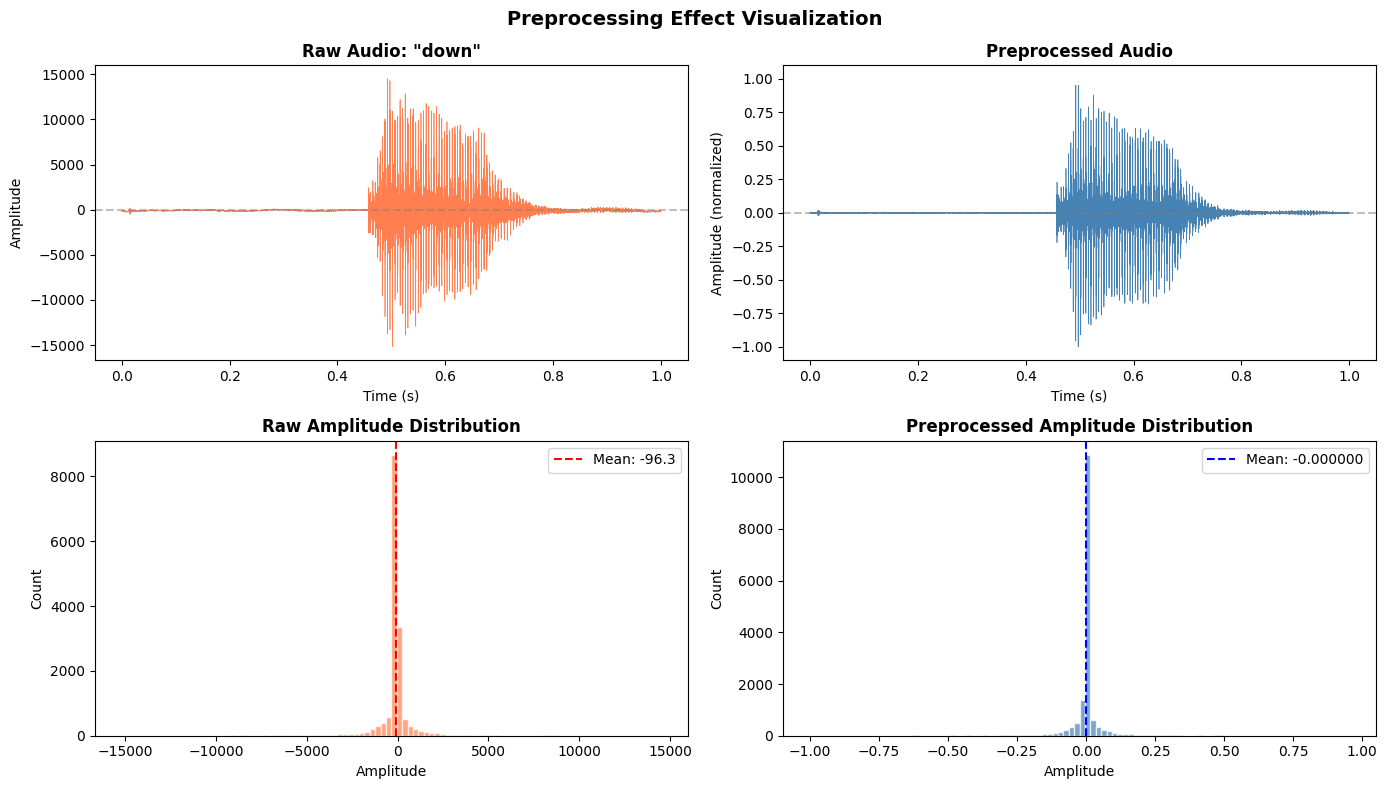


📊 Statistics Comparison:
Metric                           Raw    Preprocessed
----------------------------------------------------
Min                        -15191.00         -1.0000
Max                         14509.00          0.9526
Mean                          -96.33       -0.000000
Std Dev                      1301.50          0.0824


In [20]:
# 3.5 Visualize Preprocessing Effect
def plot_preprocessing_comparison(raw_sample: AudioSample, preprocessed: np.ndarray):
    """Visualize the effect of preprocessing on a single sample."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    
    raw = raw_sample.data
    time_raw = np.arange(len(raw)) / raw_sample.sample_rate
    time_proc = np.arange(len(preprocessed)) / Config.SAMPLE_RATE
    
    # Raw waveform
    axes[0, 0].plot(time_raw, raw, linewidth=0.5, color='coral')
    axes[0, 0].set_title(f'Raw Audio: "{raw_sample.label}"', fontweight='bold')
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Preprocessed waveform
    axes[0, 1].plot(time_proc, preprocessed, linewidth=0.5, color='steelblue')
    axes[0, 1].set_title('Preprocessed Audio', fontweight='bold')
    axes[0, 1].set_xlabel('Time (s)')
    axes[0, 1].set_ylabel('Amplitude (normalized)')
    axes[0, 1].set_ylim(-1.1, 1.1)
    axes[0, 1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Raw histogram
    axes[1, 0].hist(raw, bins=100, color='coral', alpha=0.7, edgecolor='white')
    axes[1, 0].set_title('Raw Amplitude Distribution', fontweight='bold')
    axes[1, 0].set_xlabel('Amplitude')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].axvline(x=np.mean(raw), color='red', linestyle='--', label=f'Mean: {np.mean(raw):.1f}')
    axes[1, 0].legend()
    
    # Preprocessed histogram
    axes[1, 1].hist(preprocessed, bins=100, color='steelblue', alpha=0.7, edgecolor='white')
    axes[1, 1].set_title('Preprocessed Amplitude Distribution', fontweight='bold')
    axes[1, 1].set_xlabel('Amplitude')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].axvline(x=np.mean(preprocessed), color='blue', linestyle='--', label=f'Mean: {np.mean(preprocessed):.6f}')
    axes[1, 1].legend()
    
    plt.suptitle('Preprocessing Effect Visualization', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\n📊 Statistics Comparison:")
    print(f"{'Metric':<20} {'Raw':>15} {'Preprocessed':>15}")
    print("-" * 52)
    print(f"{'Min':<20} {raw.min():>15.2f} {preprocessed.min():>15.4f}")
    print(f"{'Max':<20} {raw.max():>15.2f} {preprocessed.max():>15.4f}")
    print(f"{'Mean':<20} {raw.mean():>15.2f} {preprocessed.mean():>15.6f}")
    print(f"{'Std Dev':<20} {raw.std():>15.2f} {preprocessed.std():>15.4f}")

# Plot comparison for first sample
plot_preprocessing_comparison(cleaned_samples[0], preprocessed_audio[0])

---
## Framing

Split each audio signal into short, overlapping frames. This is essential for:
- Capturing local spectral characteristics
- Assuming quasi-stationarity within each frame
- Standard practice in speech processing

**Parameters:**
- Frame length: 25ms (400 samples at 16kHz)
- Hop length: 10ms (160 samples) → 60% overlap
- Window: Hamming (reduces spectral leakage)

In [21]:
# 4.1 Framing Functions
def split_into_frames(audio: np.ndarray,
                      frame_length_ms: float = Config.FRAME_LENGTH_MS,
                      hop_length_ms: float = Config.HOP_LENGTH_MS,
                      sample_rate: int = Config.SAMPLE_RATE) -> np.ndarray:
    """
    Split audio into overlapping frames.
    
    Args:
        audio: Input audio signal
        frame_length_ms: Frame length in milliseconds
        hop_length_ms: Hop length in milliseconds
        sample_rate: Audio sample rate
    
    Returns:
        2D array of shape (num_frames, frame_length_samples)
    """
    frame_length = int(sample_rate * frame_length_ms / 1000)
    hop_length = int(sample_rate * hop_length_ms / 1000)
    
    # Calculate number of frames
    num_frames = 1 + (len(audio) - frame_length) // hop_length
    
    if num_frames <= 0:
        # Audio too short, return single padded frame
        padded = np.pad(audio, (0, frame_length - len(audio)), mode='constant')
        return padded.reshape(1, -1)
    
    # Extract frames using stride tricks for efficiency
    frames = np.zeros((num_frames, frame_length), dtype=audio.dtype)
    for i in range(num_frames):
        start = i * hop_length
        frames[i] = audio[start:start + frame_length]
    
    return frames


def get_window(window_type: str, length: int) -> np.ndarray:
    """
    Get a window function.
    
    Args:
        window_type: Type of window ('hamming', 'hann', 'blackman')
        length: Window length in samples
    
    Returns:
        Window array
    """
    windows = {
        'hamming': np.hamming,
        'hann': np.hanning,
        'blackman': np.blackman
    }
    if window_type not in windows:
        raise ValueError(f"Unknown window type: {window_type}. Use: {list(windows.keys())}")
    return windows[window_type](length)


def apply_window(frames: np.ndarray, window_type: str = Config.WINDOW_TYPE) -> np.ndarray:
    """
    Apply a window function to frames.
    
    Args:
        frames: 2D array of frames (num_frames, frame_length)
        window_type: Type of window function
    
    Returns:
        Windowed frames
    """
    window = get_window(window_type, frames.shape[1])
    return frames * window

print("Framing functions defined")

Framing functions defined


In [22]:
# 4.2 Apply Framing to All Samples
print("Applying framing to all samples...")

# Calculate expected number of frames
frame_length = Config.frame_samples()  # 400 samples
hop_length = Config.hop_samples()      # 160 samples
num_frames = 1 + (Config.EXPECTED_SAMPLES - frame_length) // hop_length

print(f"   Frame length: {frame_length} samples ({Config.FRAME_LENGTH_MS}ms)")
print(f"   Hop length: {hop_length} samples ({Config.HOP_LENGTH_MS}ms)")
print(f"   Expected frames per sample: {num_frames}")

# Apply framing to all preprocessed audio
all_frames = []
for audio in preprocessed_audio:
    frames = split_into_frames(audio)
    windowed_frames = apply_window(frames)
    all_frames.append(windowed_frames)

# Convert to numpy array
frames_data = np.array(all_frames, dtype=np.float32)

print(f"\nFraming complete!")
print(f"Output shape: {frames_data.shape}")
print(f"(samples, frames, frame_length) = ({frames_data.shape[0]}, {frames_data.shape[1]}, {frames_data.shape[2]})")

Applying framing to all samples...
   Frame length: 400 samples (25.0ms)
   Hop length: 160 samples (10.0ms)
   Expected frames per sample: 98

Framing complete!
Output shape: (7973, 98, 400)
(samples, frames, frame_length) = (7973, 98, 400)


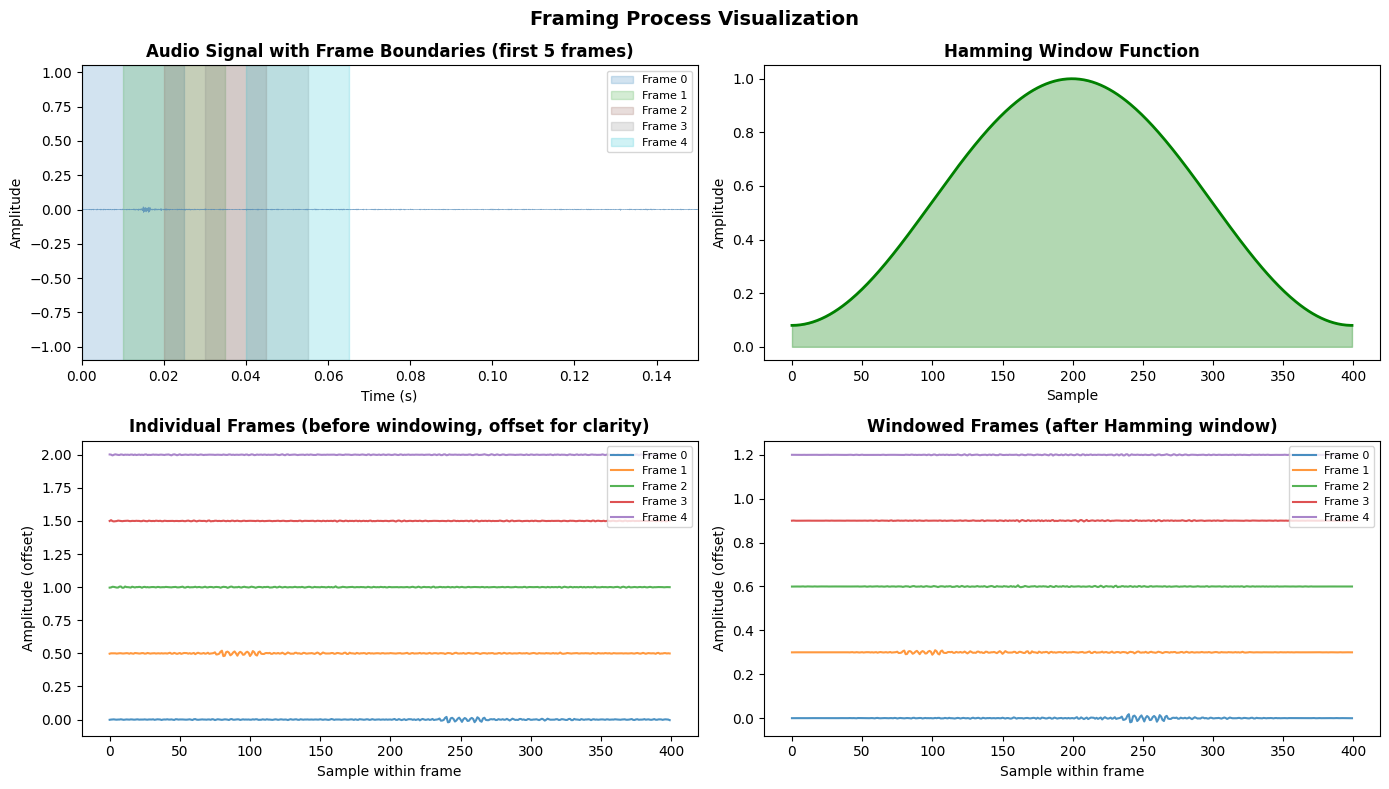

In [23]:
# 4.3 Visualize Framing Process
def plot_framing_visualization(audio: np.ndarray, frames: np.ndarray, sample_idx: int = 0):
    """Visualize the framing process."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    
    time = np.arange(len(audio)) / Config.SAMPLE_RATE
    
    # Full audio with frame boundaries
    ax1 = axes[0, 0]
    ax1.plot(time, audio, linewidth=0.5, color='steelblue', alpha=0.7)
    
    # Show first few frame boundaries
    frame_length = Config.frame_samples()
    hop_length = Config.hop_samples()
    colors = plt.cm.tab10(np.linspace(0, 1, 5))
    
    for i in range(5):
        start_sample = i * hop_length
        end_sample = start_sample + frame_length
        start_time = start_sample / Config.SAMPLE_RATE
        end_time = end_sample / Config.SAMPLE_RATE
        ax1.axvspan(start_time, end_time, alpha=0.2, color=colors[i], label=f'Frame {i}')
    
    ax1.set_title('Audio Signal with Frame Boundaries (first 5 frames)', fontweight='bold')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.set_xlim(0, 0.15)  # Zoom to first 150ms
    ax1.legend(loc='upper right', fontsize=8)
    
    # Window function
    ax2 = axes[0, 1]
    window = get_window(Config.WINDOW_TYPE, frame_length)
    ax2.plot(window, color='green', linewidth=2)
    ax2.fill_between(range(len(window)), window, alpha=0.3, color='green')
    ax2.set_title(f'{Config.WINDOW_TYPE.capitalize()} Window Function', fontweight='bold')
    ax2.set_xlabel('Sample')
    ax2.set_ylabel('Amplitude')
    
    # Individual frames (before windowing)
    ax3 = axes[1, 0]
    raw_frames = split_into_frames(audio)
    for i in range(5):
        ax3.plot(raw_frames[i] + i*0.5, label=f'Frame {i}', alpha=0.8)
    ax3.set_title('Individual Frames (before windowing, offset for clarity)', fontweight='bold')
    ax3.set_xlabel('Sample within frame')
    ax3.set_ylabel('Amplitude (offset)')
    ax3.legend(loc='upper right', fontsize=8)
    
    # Windowed frames
    ax4 = axes[1, 1]
    for i in range(5):
        ax4.plot(frames[i] + i*0.3, label=f'Frame {i}', alpha=0.8)
    ax4.set_title('Windowed Frames (after Hamming window)', fontweight='bold')
    ax4.set_xlabel('Sample within frame')
    ax4.set_ylabel('Amplitude (offset)')
    ax4.legend(loc='upper right', fontsize=8)
    
    plt.suptitle('Framing Process Visualization', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize for first sample
plot_framing_visualization(preprocessed_audio[0], frames_data[0])

---
## Save Processed Data

Save the preprocessed data to disk for later use. This avoids reprocessing every time.

In [26]:
# 5.1 Data Persistence Functions
def save_processed_data(labels: np.ndarray,
                        audio_data: np.ndarray,
                        frames_data: np.ndarray,
                        filepaths: List[str],
                        metadata: Dict[str, Any],
                        output_dir: Path = Config.PROCESSED_DATA_DIR) -> Path:
    """
    Save preprocessed data to disk.
    
    Args:
        labels: Array of label strings
        audio_data: 2D array of preprocessed audio (n_samples, n_audio_samples)
        frames_data: 3D array of frames (n_samples, n_frames, frame_length)
        filepaths: List of original file paths
        metadata: Dictionary with preprocessing parameters
        output_dir: Directory to save files
    
    Returns:
        Path to the output directory
    """
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Save arrays as compressed numpy files
    np.savez_compressed(
        output_dir / "preprocessed_data.npz",
        labels=labels,
        audio=audio_data,
        frames=frames_data
    )
    
    # Save filepaths and metadata as JSON
    meta_to_save = {
        "filepaths": filepaths,
        "metadata": metadata,
        "shapes": {
            "labels": list(labels.shape),
            "audio": list(audio_data.shape),
            "frames": list(frames_data.shape)
        }
    }
    
    with open(output_dir / "metadata.json", "w") as f:
        json.dump(meta_to_save, f, indent=2)
    
    return output_dir


def load_processed_data(input_dir: Path = Config.PROCESSED_DATA_DIR):
    """
    Load preprocessed data from disk.
    
    Returns:
        Tuple of (labels, audio_data, frames_data, filepaths, metadata)
    """
    data = np.load(input_dir / "preprocessed_data.npz")
    
    with open(input_dir / "metadata.json", "r") as f:
        meta = json.load(f)
    
    return (
        data["labels"],
        data["audio"],
        data["frames"],
        meta["filepaths"],
        meta["metadata"]
    )


def processed_data_exists(input_dir: Path = Config.PROCESSED_DATA_DIR) -> bool:
    """Check if processed data already exists."""
    return (input_dir / "preprocessed_data.npz").exists()

print("Data persistence functions defined")

Data persistence functions defined


In [25]:
# 5.2 Save Processed Data
print("Saving processed data to disk...")

# Prepare metadata
metadata = {
    "original_sample_count": original_count,
    "duplicates_removed": duplicates_removed,
    "sample_rate": Config.SAMPLE_RATE,
    "expected_samples": Config.EXPECTED_SAMPLES,
    "frame_length_ms": Config.FRAME_LENGTH_MS,
    "hop_length_ms": Config.HOP_LENGTH_MS,
    "window_type": Config.WINDOW_TYPE,
    "preemphasis_coeff": Config.PREEMPHASIS_COEFF
}

# Get filepaths
filepaths = [str(s.filepath) for s in cleaned_samples]

# Save
output_path = save_processed_data(
    labels=labels,
    audio_data=preprocessed_audio,
    frames_data=frames_data,
    filepaths=filepaths,
    metadata=metadata
)

# Get file size
import os
npz_size = os.path.getsize(output_path / "preprocessed_data.npz")
size_str = f"{npz_size / (1024**3):.2f} GB" if npz_size > 1024**3 else f"{npz_size / (1024**2):.1f} MB"

print(f"\nData saved successfully!")
print(f"Location: {output_path}")
print(f"Size: {size_str}")
print(f"\nFiles created:")
print(f"- preprocessed_data.npz (labels, audio, frames)")
print(f"- metadata.json (config & filepaths)")

Saving processed data to disk...

Data saved successfully!
Location: /kaggle/working/processed_data
Size: 1.41 GB

Files created:
- preprocessed_data.npz (labels, audio, frames)
- metadata.json (config & filepaths)


In [34]:
# Final Summary 

print("=" * 70)
print("🎉 SPEECH RECOGNITION PIPELINE - STAGES 1 & 2 COMPLETE")
print("=" * 70)

print("\n📊 DATA SUMMARY")
print("-" * 70)
print(f"   Original samples:      {original_count:,}")
print(f"   Duplicates removed:    {duplicates_removed:,}")
print(f"   Final sample count:    {cleaned_count:,}")

print("\n📁 SAMPLES PER LABEL")
print("-" * 70)
unique_labels, label_counts = np.unique(labels, return_counts=True)
for lbl, cnt in zip(unique_labels, label_counts):
    print(f"   {lbl:>10}: {cnt:>5} samples")

print("\n🔧 PREPROCESSING APPLIED")
print("-" * 70)
print("   ✓ DC offset removal (zero-centered)")
print("   ✓ Length normalization (padded to 1 second)")
print(f"   ✓ Pre-emphasis filter (coeff={Config.PREEMPHASIS_COEFF})")
print("   ✓ Amplitude normalization ([-1, 1])")

print("\n🪟 FRAMING CONFIGURATION")
print("-" * 70)
print(f"   Frame length:    {Config.FRAME_LENGTH_MS} ms ({Config.frame_samples()} samples)")
print(f"   Hop length:      {Config.HOP_LENGTH_MS} ms ({Config.hop_samples()} samples)")
print(f"   Overlap:         {Config.FRAME_LENGTH_MS - Config.HOP_LENGTH_MS} ms (60%)")
print(f"   Window:          {Config.WINDOW_TYPE}")
print(f"   Frames/sample:   {frames_data.shape[1]}")

print("\n📦 OUTPUT DATA SHAPES")
print("-" * 70)
print(f"   Labels:          {labels.shape}")
print(f"   Audio:           {preprocessed_audio.shape} (samples × audio_length)")
print(f"   Frames:          {frames_data.shape} (samples × frames × frame_length)")
print(f"   Total frames:    {frames_data.shape[0] * frames_data.shape[1]:,}")

🎉 SPEECH RECOGNITION PIPELINE - STAGES 1 & 2 COMPLETE

📊 DATA SUMMARY
----------------------------------------------------------------------
   Original samples:      8,000
   Duplicates removed:    27
   Final sample count:    7,973

📁 SAMPLES PER LABEL
----------------------------------------------------------------------
         down:   998 samples
           go:   994 samples
         left:   996 samples
           no:   998 samples
        right:   998 samples
         stop:   996 samples
           up:   997 samples
          yes:   996 samples

🔧 PREPROCESSING APPLIED
----------------------------------------------------------------------
   ✓ DC offset removal (zero-centered)
   ✓ Length normalization (padded to 1 second)
   ✓ Pre-emphasis filter (coeff=0.97)
   ✓ Amplitude normalization ([-1, 1])

🪟 FRAMING CONFIGURATION
----------------------------------------------------------------------
   Frame length:    25.0 ms (400 samples)
   Hop length:      10.0 ms (160 samples)
   

## Train / Test Split

In [29]:
print("Splitting data into Train (80%) and Test (20%) – stratified\n")

X_frames_train, X_frames_test, \
y_train, y_test = train_test_split(
    frames_data,           
    labels,                
    test_size=0.20,
    random_state=42,
    stratify=labels,
    shuffle=True
)

print(f"Training set   : {X_frames_train.shape[0]} samples")
print(f"Testing set    : {X_frames_test.shape[0]} samples")
print(f"Frames per sample : {X_frames_train.shape[1]}")
print(f"Frame length      : {X_frames_train.shape[2]} samples\n")

# Quick check 
unique, counts = np.unique(y_test, return_counts=True)
for cls, cnt in zip(unique, counts):
    print(f"  {cls:>8} → {cnt} test samples")

print("\nTrain/Test split completed successfully!")

Splitting data into Train (80%) and Test (20%) – stratified

Training set   : 6378 samples
Testing set    : 1595 samples
Frames per sample : 98
Frame length      : 400 samples

      down → 200 test samples
        go → 199 test samples
      left → 199 test samples
        no → 200 test samples
     right → 200 test samples
      stop → 199 test samples
        up → 199 test samples
       yes → 199 test samples

Train/Test split completed successfully!


## Compute FFT → Magnitude Spectrum (Features)

Computing magnitude spectrum for train and test frames...

Training spectra shape : (6378, 98, 201)
Testing spectra shape  : (1595, 98, 201)


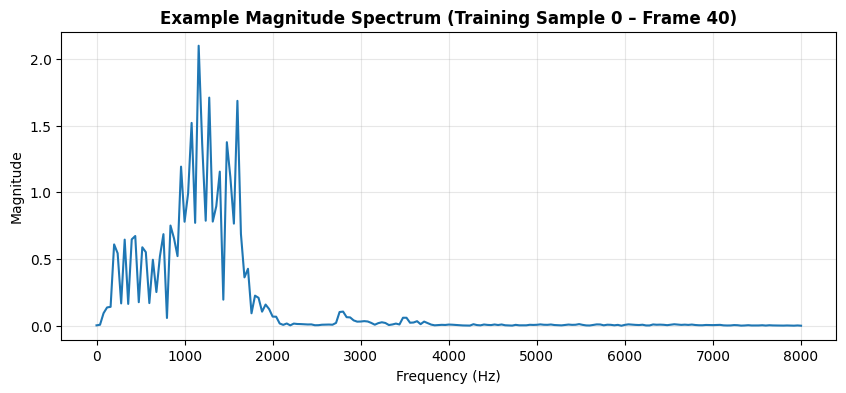

In [32]:
print("Computing magnitude spectrum for train and test frames...\n")

# FFT (real input → rfft)
X_train_spectrum = np.abs(np.fft.rfft(X_frames_train, axis=2)).astype(np.float32)
X_test_spectrum  = np.abs(np.fft.rfft(X_frames_test,  axis=2)).astype(np.float32)

print(f"Training spectra shape : {X_train_spectrum.shape}")   # (6378, 98, 201)
print(f"Testing spectra shape  : {X_test_spectrum.shape}")    # (1595, 98, 201)

plt.figure(figsize=(10,4))
plt.plot(np.linspace(0, 8000, X_train_spectrum.shape[2]), X_train_spectrum[0, 40])
plt.title("Example Magnitude Spectrum (Training Sample 0 – Frame 40)", fontweight='bold')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(alpha=0.3)
plt.show()